In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

In [1]:
datasetName = 'Blood_Blood_HCLAdult-Peripheral-Blood4'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/home/bianhaiyang/hcad/hcl/hcl_all/Blood_Blood_HCLAdult-Peripheral-Blood4")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

In [2]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [3]:
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

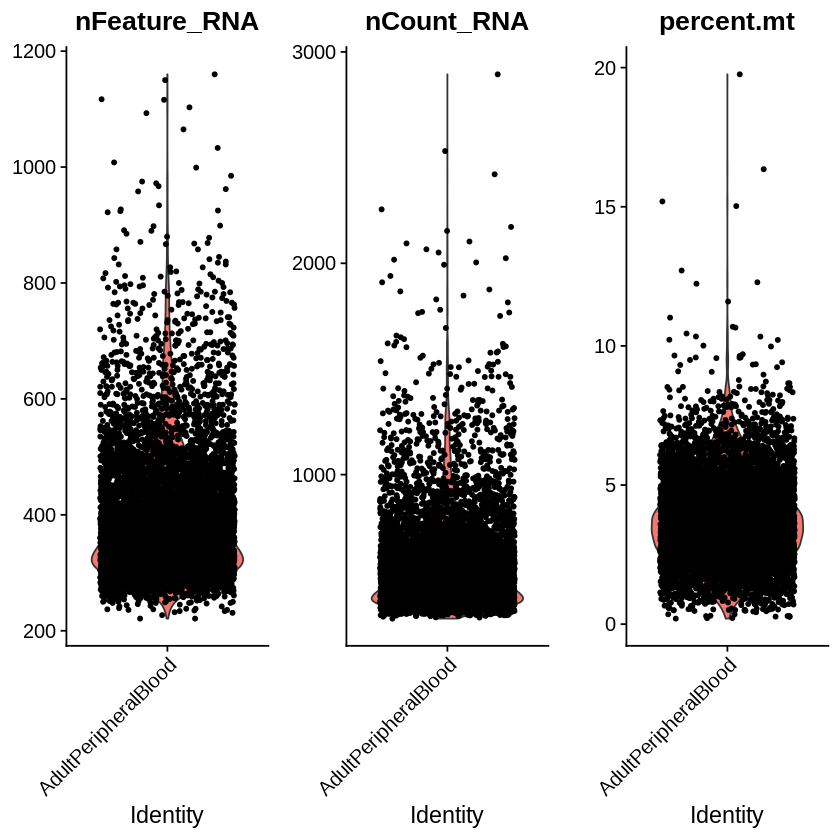

In [4]:
# Visualize QC metrics as a violin plot
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

## 下面要调

In [5]:
# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(20, 3000)
percent.mt.thre = 20

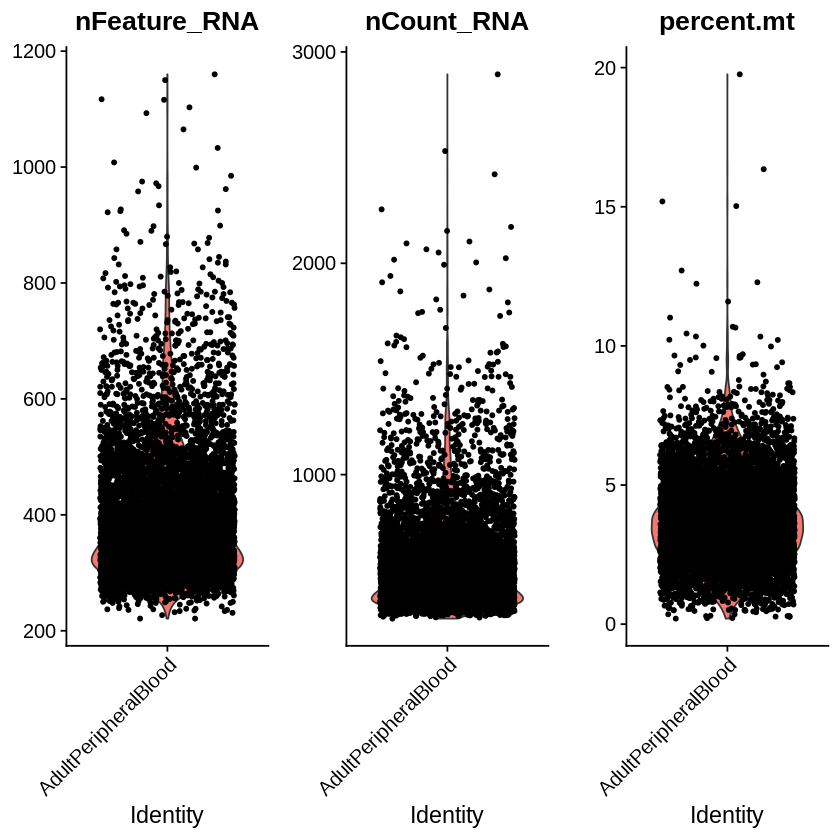

In [6]:
# QC
#dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Visualize QC metrics as a violin plot
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()


PC_ 1 
Positive:  RPS27, RPS29, RPS18, TRBC2, RPL21, IL32, RPS27A, RPS3, RPL23A, RPS19 
	   CD3D, RPS6, RPS14, RPS12, TRAC, RPL13, RPL27A, RPL13A, RPS25, RPL10 
	   CCL5, RPL3, RPS15A, RPL34, RPS3A, IFITM1, PCED1B-AS1, RPL31, RPLP2, TRBC1 
Negative:  FTL, LYZ, S100A9, S100A8, FTH1, S100A12, CD14, FOLR3, CD74, S100A4 
	   RP11-1143G9.4, HLA-DRA, RGS2, HLA-DRB1, CSF3R, SRGN, SAT1, ACTB, MT-TI, VCAN 
	   CD36, PLBD1, TYMP, DUSP1, CDA, KCTD12, NCF1C, PTAFR, BST1, IFITM3 
PC_ 2 
Positive:  BPI, CD24, CEACAM8, ANXA3, DEFA4, S100P, CEACAM6, SLPI, AZU1, MS4A3 
	   RNASE3, ELANE, DEFA3, PGLYRP1, LTF, LCN2, CTSG, RNASE2, MPO, RGL4 
	   DPY19L1P1, CEBPE, CHI3L1, CAMP, ARG1, TCN1, RETN, MMP8, COL17A1, CD59 
Negative:  CD74, FTH1, HLA-DRA, HLA-DRB1, HLA-DPA1, TMSB10, FTL, S100A4, HLA-DPB1, HLA-DQA1 
	   HLA-DQA2, HLA-DQB1, SAT1, IFITM3, NAPSB, FCER1A, LINC01272, CD14, POU2F2, FCGR3A 
	   TYMP, HLA-DRB5, EEF1A1, MS4A7, WARS, OAS1, CLEC10A, CD1C, CSF1R, RHOC 
PC_ 3 
Positive:  GNLY, CCL5, IL32, NKG7,

png 
  2

Warning message in ElbowPlot(dataobj, 100):
"The object only has information for 50 reductions"

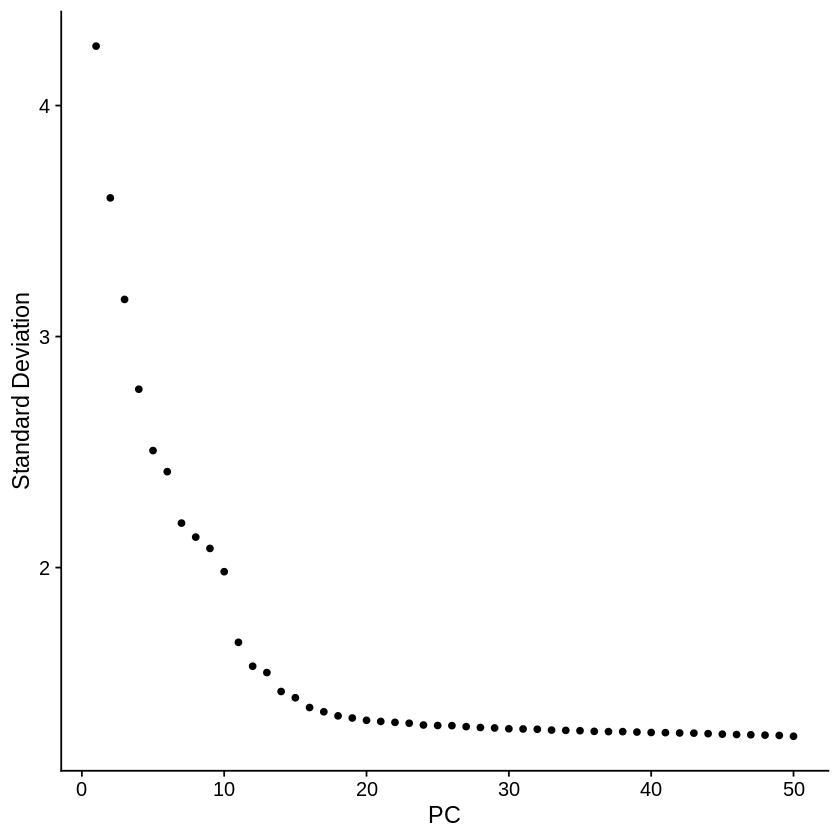

In [11]:
ElbowPlot(dataobj,100) 

## 下面要调

In [12]:
pcDim = 20
# Cluster the cells
dataobj2 <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj2 <- FindClusters(dataobj2, resolution = 1, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7160
Number of edges: 281583

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8153
Number of communities: 18
Elapsed time: 1 seconds


In [10]:
pcDim = 30
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.8, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2156
Number of edges: 121688

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7067
Number of communities: 9
Elapsed time: 0 seconds


In [13]:
# Visulize the clustering result
dataobj3 <- RunUMAP(dataobj2, dims = 1:pcDim)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"10:30:50 UMAP embedding parameters a = 0.9922 b = 1.112
10:30:50 Read 7160 rows and found 20 numeric columns
10:30:50 Using Annoy for neighbor search, n_neighbors = 30
10:30:50 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
10:30:51 Writing NN index file to temp file /tmp/RtmpNBjpxs/file74da6358674d
10:30:51 Searching Annoy index using 1 thread, search_k = 3000
10:30:53 Annoy recall = 100%
10:30:53 Commencing smooth kNN distance calibration using 1 thread
10:30:54 Initializing from normalized Laplacian + noise
10:30:54 Commencing optimizatio

In [23]:
p_umap <- DimPlot(dataobj3, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

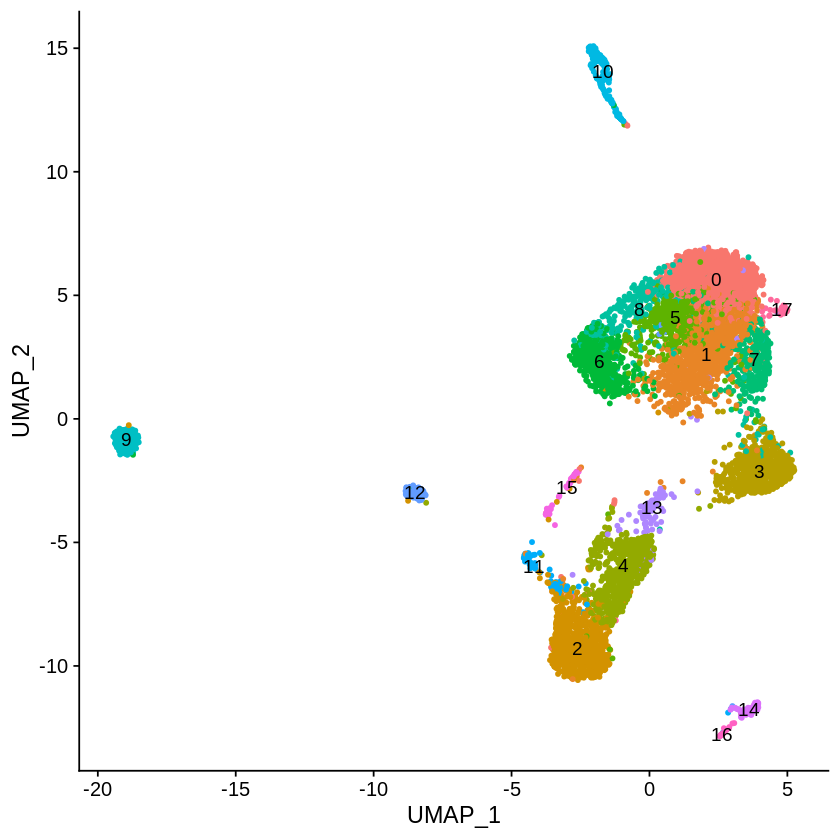

In [24]:
p_umap

In [25]:
p_umap2 <- DimPlot(dataobj3, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

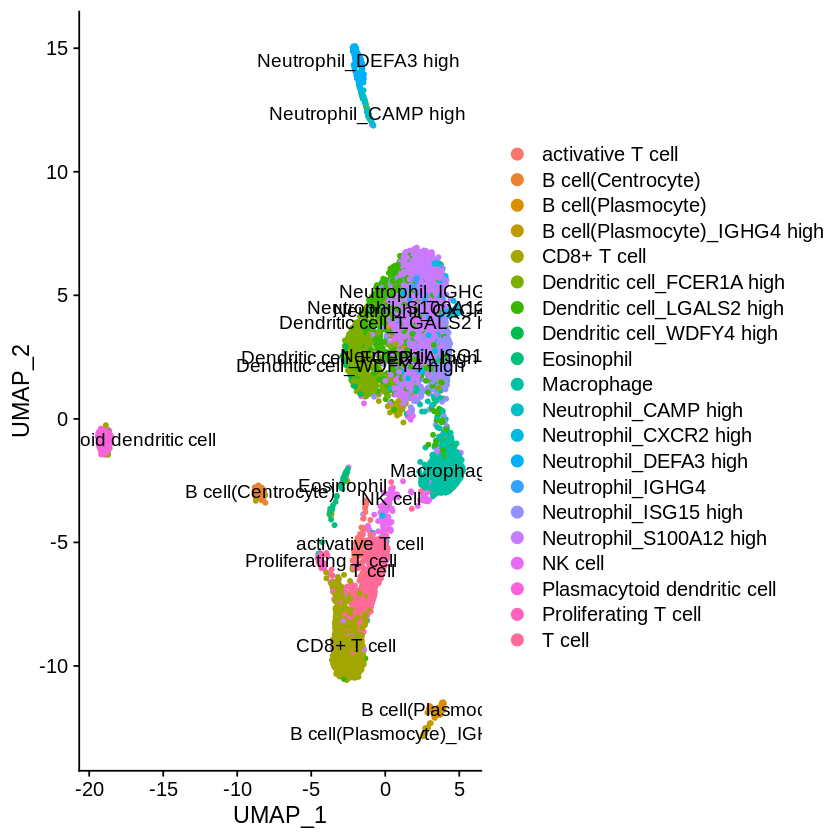

In [26]:
p_umap2

In [6]:

# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
